### Video-Based Gaze Tracking tutorial (2/5)
This is a lecture of the Video-Based Gaze Tracking tutorial of the [Bridging the Technological Gap Summer Workshop](https://psychandneuro.duke.edu/opportunity/bridging-technological-gap-summer-workshop), July 31st – August 6th, 2022, German Primate Center, Göttingen, Germany.

More info at [https://github.com/erkil1452/gaze_workshop_public](https://github.com/erkil1452/gaze_workshop_public).

Made by Petr Kellnhofer, 2022.

In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path('.').resolve().absolute().parent))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import cv2
import imageio
import dlib
import nbimporter

# Automatically reload our library.
%reload_ext autoreload
%autoreload 1
from src import gaze_utils as gu
%aimport src

# Import solutions from our previous notebook(s).
from s01_capture import capture_frame, detect_face, crop_image

DATA_PATH = Path('.').resolve().absolute().parent / 'data'
sample_data = gu.WorkshopDataset(DATA_PATH / 'gazecapture' / '00192')

## 2. Eye detection.

In this section, we will see how to detect eyes. This assumes we already have a face detector from Section 1.

First, we will get ourselves a face crop:

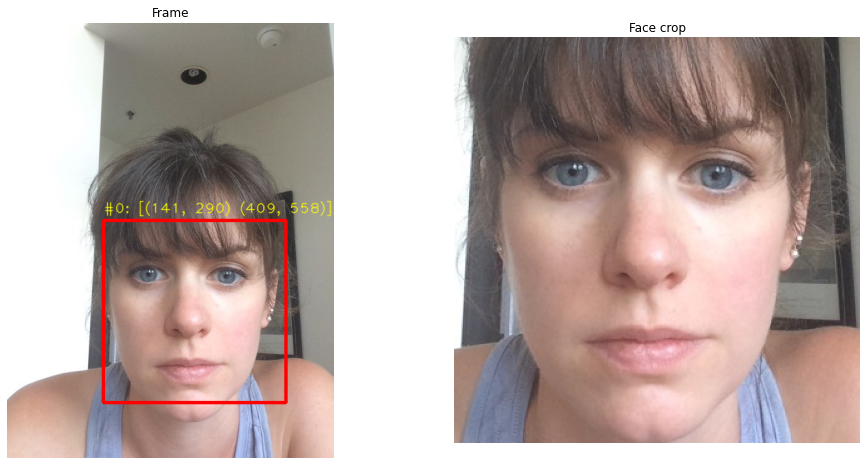

In [2]:
# frame = capture_frame()
# OR:
frame = sample_data.get_image(0)
rect = detect_face(frame)
face_crop = crop_image(frame, rect)
gu.show_images([gu.draw_rectangles(frame.copy(),[rect]), face_crop], ['Frame', 'Face crop'])

It turns out that the convenient dlib library also offers a more general shape detector that can be trained to detect any keypoints. In the example below we initialize it with parameters that detect 68 keypoints defined on face.

In [4]:
landmark_detector = dlib.shape_predictor(str(DATA_PATH / 'params/shape_predictor_68_face_landmarks.dat'))

The method expects an image and a rectangle of the face region. We can either first crop the face and then run on the entire crop - or - provide the entire image and the face rectangle parameters.

In [4]:
# Either run for the entire cropped face image.
landmarks = landmark_detector(face_crop, dlib.rectangle(0, 0, face_crop.shape[1] - 1, face_crop.shape[0] - 1))

# # OR run on the full image with the face rectangle as additional input.
# landmarks = landmark_detector(frame, rect)

landmarks = np.array([[p.x, p.y] for p in landmarks.parts()], int)
print(f'Detected {len(landmarks)} landmarks. Showing first 5:\n{landmarks[:5]}...')


Detected 68 landmarks. Showing first 5:
[[ 32 109]
 [ 32 141]
 [ 36 173]
 [ 40 206]
 [ 51 237]]...


The output is 68 2D points in pixel coordinates which we easily visualize:

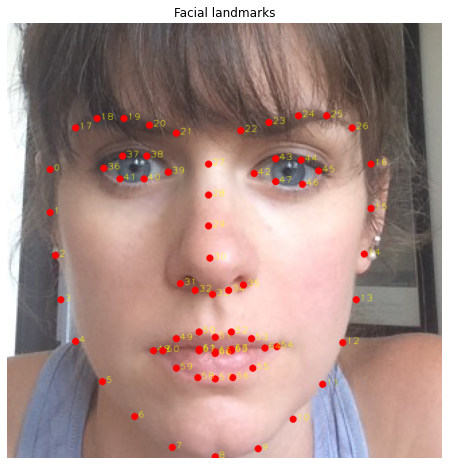

In [5]:
viz_scale = 4
im = cv2.resize(face_crop.copy(), None, fx=viz_scale, fy=viz_scale, interpolation=cv2.INTER_NEAREST)
for i,pt in enumerate(landmarks):
    cv2.circle(im, tuple(pt*viz_scale), radius=10, color=(255, 0, 0), thickness=-1, lineType=cv2.LINE_AA)
    cv2.putText(im, f'{i}', tuple(pt*viz_scale + (10, 5)), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 0), 1, lineType = cv2.LINE_AA)
gu.show_images([im], ['Facial landmarks']);   

The order of the points is defined and fixed, so we can determine which points belong to each eye and mark them with color.

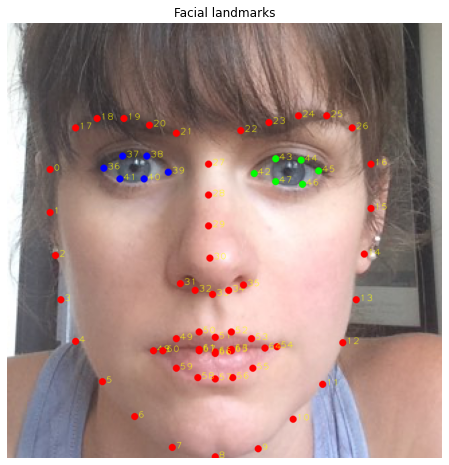

In [6]:
left_eye_marks = landmarks[42:48]
right_eye_marks = landmarks[36:42]
for i,pt in enumerate(left_eye_marks):
    cv2.circle(im, tuple(pt*viz_scale), radius=10, color=(0, 255, 0), thickness=-1, lineType=cv2.LINE_AA)
for i,pt in enumerate(right_eye_marks):
    cv2.circle(im, tuple(pt*viz_scale), radius=10, color=(0, 0, 255), thickness=-1, lineType=cv2.LINE_AA)
gu.show_images([im], ['Facial landmarks']);   

Then we could find bounding box of each eye, crop them and use them as additional inputs to our neural network (as [iTracker](https://gazecapture.csail.mit.edu/cvpr2016_gazecapture.pdf) does).

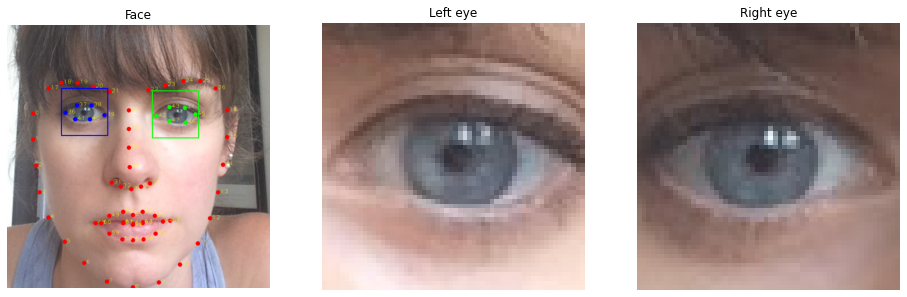

In [7]:
def get_pts_bbox(pts, margin_factor):
    pt_min = np.min(pts, axis=0)
    pt_max = np.max(pts, axis=0)
    c = (pt_min + pt_max) / 2
    r = (pt_max - pt_min).max() / 2 * margin_factor
    return (c - r).astype(int), (c + r).astype(int)

le_lt, le_rb = get_pts_bbox(left_eye_marks, 1.2)
re_lt, re_rb = get_pts_bbox(right_eye_marks, 1.2)

left_eye = face_crop[le_lt[1]:le_rb[1]+1, le_lt[0]:le_rb[0]+1]
right_eye = face_crop[re_lt[1]:re_rb[1]+1, re_lt[0]:re_rb[0]+1]

cv2.rectangle(im, tuple(le_lt*viz_scale), tuple(le_rb*viz_scale), color=(0, 255, 0), thickness=4)
cv2.rectangle(im, tuple(re_lt*viz_scale), tuple(re_rb*viz_scale), color=(0, 0, 255), thickness=4)

gu.show_images([im, left_eye, right_eye], ['Face', 'Left eye', 'Right eye'])

Note, that we could have used the same method as for cropping faces to handle eye regions potentially sticking out of the image bounds.

However, to keep things simple, for the rest of the tutorial we will only use the face images as inputs to our neural network.